In [ ]:
import squidpy as sq
import scanpy as sc
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix, isspmatrix_csr

In [ ]:
import liana as li

In [ ]:
from matplotlib.pyplot import hist

In [ ]:
counts = pd.read_csv("data/counts_mat.csv")
weights = pd.read_csv("data/weight_mat.csv")

In [ ]:
var = pd.DataFrame(counts[['Unnamed: 0']]).set_index('Unnamed: 0')
var.index.name = None

In [ ]:
adata = sc.AnnData(X=csr_matrix(counts.drop(counts.columns[0], axis=1), dtype=np.float32).T, var=var)

In [ ]:
adata.obsm['proximity'] = csr_matrix(weights)

In [ ]:
from liana.method._global_lr_pipe import _global_lr_pipe
from liana.method.sp._spatialdm import _get_ordered_matrix, _standardize_matrix

In [ ]:
adata.write_h5ad("test_spatial.h5ad")

In [ ]:
resource = pd.DataFrame({"ligand":["Dnm1l", "Arrb1", "Igf2"], "receptor":["Gucy1b3", "Mtor", "Tuba1a"]})

In [ ]:
temp, lr_res, ligand_pos, receptor_pos = _global_lr_pipe(adata=adata,
                                                         resource=resource,
                                                         expr_prop=0.05,
                                                         use_raw=False,
                                                         verbose=True,
                                                         layer=None,
                                                         _key_cols=['ligand_complex', 'receptor_complex'],
                                                         _complex_cols=['ligand_means', 'receptor_means'],
                                                         _obms_keys=['proximity'],
                                                         resource_name=None
                                                         )

In [ ]:
lr_res

Correlations

In [ ]:
ligand_mat = _get_ordered_matrix(temp.X, ligand_pos, lr_res.ligand)
receptor_mat = _get_ordered_matrix(temp.X, receptor_pos, lr_res.receptor)

In [ ]:
x, y = ligand_mat[0, :].A.flatten(), receptor_mat[0, :].A.flatten()

In [ ]:
from scipy.stats import spearmanr, pearsonr, pointbiserialr, kendalltau

In [ ]:
pearsonr(x, y)

One by One

In [ ]:
def wcor(x, y, weight):
    weight_sum = np.sum(weight)
    
    numerator = weight_sum * np.sum(weight * x * y) - np.sum(weight * x) * np.sum(weight * y)
    denominator_x = weight_sum * np.sum(weight * (x**2)) - np.sum(weight * x)**2
    denominator_y = weight_sum * np.sum(weight * (y**2)) - np.sum(weight * y)**2
    
    wcor = numerator / np.sqrt(denominator_x * denominator_y)
    
    return wcor

In [ ]:
adata.obsm['proximity']

In [ ]:
i = 0

In [ ]:
# all weights = 1 (i.e. pearsonr)
wcor(x, y, np.repeat(1, x.shape[0]))

In [ ]:
weight = adata.obsm['proximity']

In [ ]:
# calculate all local correlations
# technically, if we take i (a spot), x and y (e.g. genes),
# we go over all rows in w (i.e. every spot)
# and we re-calculate PC with the spatial weights 
# for the spots i to any other spot (j)
local_corrs = []
for i in range(weight.shape[0]):
    local_corrs.append(wcor(x, y, weight[i, :].A))
local_corrs = np.array(local_corrs)

In [ ]:
hist(local_corrs)

In [ ]:
local_corrs[0:5]

In [ ]:
weight = weight[0, :].A

In [ ]:
weight_sum = np.sum(weight)

numerator = weight_sum * np.sum(weight * x * y) - np.sum(weight * x) * np.sum(weight * y)
denominator_x = weight_sum * np.sum(weight * (x**2)) - np.sum(weight * x)**2
denominator_y = weight_sum * np.sum(weight * (y**2)) - np.sum(weight * y)**2

# wcov
numerator / np.sqrt(denominator_x * denominator_y)

In [ ]:
numerator

In [ ]:
denominator_x

In [ ]:
denominator_y

In [ ]:
weight_sum * np.sum(weight * x * y)

In [ ]:
np.sum(weight * x) * np.sum(weight * y)

In [ ]:
(weight * x)[0][0:5]

Vectorize

For one interaction at a time:

In [ ]:
weight = adata.obsm["proximity"].A ## does it really need to be A?

In [ ]:
weight_sums = np.sum(weight, axis = 1).flatten()

In [ ]:
n1 = (weight_sums * np.sum(np.multiply(weight, x) * y, axis=1))
n1

In [ ]:
n2 = np.sum(np.multiply(weight, x), axis=1) * np.sum(np.multiply(weight, y), axis=1)
n2

In [ ]:
numerator = n1 - n2

In [ ]:
numerator[0:5]

In [ ]:
denominator_x = weight_sum * np.sum(np.multiply(weight, (x**2)), axis = 1) - np.sum(np.multiply(weight,  x), axis=1)**2
denominator_y = weight_sum * np.sum(np.multiply(weight, (y**2)), axis = 1) - np.sum(np.multiply(weight,  y), axis=1)**2

In [ ]:
denominator_x.shape

In [ ]:
denominator_x[0:5]

In [ ]:
denominator_y[0:5]

In [ ]:
local_corrs = numerator / np.sqrt(denominator_x * denominator_y)

In [ ]:
hist(local_corrs)

All local corrs for all interactions

In [ ]:
ligand_mat

In [ ]:
receptor_mat

In [ ]:
weight = adata.obsm["proximity"].A.T ## does it really need to be A?

In [ ]:
weight_sums = np.sum(weight, axis = 0).flatten()

In [ ]:
x_mat = ligand_mat.A.T
y_mat = receptor_mat.A.T

In [ ]:
from scipy.stats import rankdata

In [ ]:
# x_mat = rankdata(x_mat, axis=0)
# y_mat = rankdata(y_mat, axis=0)

In [ ]:
n1 = (((x_mat * y_mat).T @ weight) * weight_sums.T)

In [ ]:
n1[0:5, 0]

In [ ]:
n2 = (x_mat.T @ weight) * (y_mat.T @ weight)

In [ ]:
numerator = n1 - n2

In [ ]:
numerator[0,0:5]

In [ ]:
denominator_x = (weight_sums * (x_mat ** 2).T @ weight) - (x_mat.T @ weight)**2
denominator_y = (weight_sums * (y_mat ** 2).T @ weight) - (y_mat.T @ weight)**2

In [ ]:
denominator_x[0, 0:5]

In [ ]:
denominator_y[0, 0:5]

In [ ]:
local_corrs = (numerator / np.sqrt(denominator_x * denominator_y)).T

In [ ]:
hist(local_corrs[:,0])

In [ ]:
local_corrs[0:5,0]

Clean

In [30]:
import squidpy as sq
import scanpy as sc
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix, isspmatrix_csr

In [31]:
import liana as li

In [32]:
from matplotlib.pyplot import hist

In [33]:
from liana.method._global_lr_pipe import _global_lr_pipe
from liana.method.sp._spatialdm import _get_ordered_matrix, _standardize_matrix

In [34]:
from scipy.stats import rankdata

In [35]:
# toy data and toy resource
adata = sc.read_h5ad("test_spatial.h5ad")
resource = pd.DataFrame({"ligand":["Dnm1l", "Arrb1", "Igf2"], "receptor":["Gucy1b3", "Mtor", "Tuba1a"]})

In [36]:
temp, lr_res, ligand_pos, receptor_pos = _global_lr_pipe(adata=adata,
                                                         resource=resource,
                                                         expr_prop=0.05,
                                                         use_raw=False,
                                                         verbose=True,
                                                         layer=None,
                                                         _key_cols=['ligand_complex', 'receptor_complex'],
                                                         _complex_cols=['ligand_means', 'receptor_means'],
                                                         _obms_keys=['proximity'],
                                                         resource_name=None
                                                         )

Using `.X`!
Converting mat to CSR format


In [242]:
# ligand-receptor mats
ligand_mat = _get_ordered_matrix(temp.X, ligand_pos, lr_res.ligand)
receptor_mat = _get_ordered_matrix(temp.X, receptor_pos, lr_res.receptor)

In [243]:
x_mat = ligand_mat.A
y_mat = receptor_mat.A

In [244]:
dist = adata.obsm['proximity']

In [266]:
def calculate_local_correlations(x_mat, y_mat, dist, method="pearson"):
    if method not in ["pearson", "spearman", "spearman_nz"]:
        raise ValueError("method must be one of 'pearson', 'spearman', 'spearman_nz'")
    
    weight = dist.A.T ## does it really need to be A?
    weight_sums = np.sum(weight, axis = 0).flatten()
        
    if method=="spearman":
        x_mat = rankdata(x_mat, axis=1)
        y_mat = rankdata(y_mat, axis=1)
    
    # standard pearson
    n1 = (((x_mat * y_mat).dot(weight)) * weight_sums)
    n2 = (x_mat.dot(weight)) * (y_mat.dot(weight))
    numerator = n1 - n2
    
    denominator_x = (weight_sums * (x_mat ** 2).dot(weight)) - (x_mat.dot(weight))**2
    denominator_y = (weight_sums * (y_mat ** 2).dot(weight)) - (y_mat.dot(weight))**2
    
    local_corrs = (numerator / np.sqrt(denominator_x * denominator_y))
    
    return local_corrs

In [267]:
local_pc = calculate_local_correlations(x_mat, y_mat, dist, method="pearson")
local_sp = calculate_local_correlations(x_mat, y_mat, dist, method="spearman")
local_spnz = calculate_local_correlations(x_mat, y_mat, dist, method="spearman_nz")

In [ ]:
rankdata()

In [272]:
weight = dist.A.T ## does it really need to be A?

In [343]:
np.mean(x_mat.dot(weight))

15.733572500753096

In [344]:
msk = np.int16(weight==0)

In [363]:
weight2 = np.ma.masked_array(data = weight, mask=msk, fill_value=np.nan)

In [355]:
x_mat2 = np.ma.masked_array(x_mat, mask=np.isnan(x_mat))

In [351]:
x_mat.shape

(3, 260)

In [352]:
xx = np.ma.masked_array.dot(x_mat2, weight2)

In [369]:
weight2 * 2

masked_array(
  data=[[2.0, --, 1.333333333333334, ..., --, --, 1.166666666666666],
        [1.0, 2.0, 1.833333333333334, ..., --, --, 1.333333333333334],
        [1.666666666666666, 1.833333333333334, 2.0, ..., --, --,
         1.666666666666666],
        ...,
        [--, --, --, ..., 2.0, --, --],
        [--, --, --, ..., --, 2.0, --],
        [1.333333333333334, 1.166666666666666, 1.666666666666666, ...,
         --, --, 2.0]],
  mask=[[False,  True, False, ...,  True,  True, False],
        [False, False, False, ...,  True,  True, False],
        [False, False, False, ...,  True,  True, False],
        ...,
        [ True,  True,  True, ..., False,  True,  True],
        [ True,  True,  True, ...,  True, False,  True],
        [False, False, False, ...,  True,  True, False]],
  fill_value=nan)

In [353]:
np.mean(xx)

masked

(array([ 3., 12., 20., 38., 36., 50., 36., 37., 23.,  5.]),
 array([-0.70673671, -0.57224594, -0.43775517, -0.30326441, -0.16877364,
        -0.03428288,  0.10020789,  0.23469865,  0.36918942,  0.50368018,
         0.63817095]),
 <BarContainer object of 10 artists>)

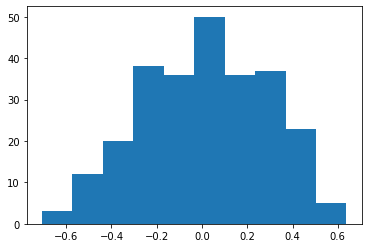

In [268]:
hist(local_spnz[0,:])

In [269]:
from scipy.stats import spearmanr, pearsonr

In [271]:
pearsonr(local_spnz[0,:], local_sp[0,:])

(1.0, 0.0)

local p-values

In [108]:
from numpy import random
from tqdm import tqdm

In [109]:
rng = random.default_rng()
n_perm = 1000
positive_only = True # remove this option?

In [110]:
local_pc.shape

(3, 260)

In [131]:
def _get_local_permutation_pvals(x_mat, y_mat, truth, function, dist, n_perm, positive_only=True, **kwargs):
    xy_n = truth.shape[0]
    spot_n = truth.shape[1]
    
    # permutation cubes to be populated
    local_pvals = np.zeros((xy_n, spot_n))
    
    # shuffle the matrix
    for i in tqdm(range(n_perm)):
        _idx = rng.permutation(spot_n)
        perm_r = function(x_mat = x_mat[:, _idx], y_mat=y_mat, dist=dist, **kwargs)
        if positive_only:
            local_pvals += np.array(perm_r >= truth, dtype=int)
        else:
            local_pvals += (np.array(np.abs(perm_r) >= np.abs(truth), dtype=int))

    local_pvals = local_pvals / n_perm
    
    return local_pvals
    

In [132]:
local_pvals = _get_local_permutation_pvals(x_mat, y_mat, local_pc, calculate_local_correlations, dist, n_perm, positive_only=True)

100%|██████████| 1000/1000 [00:00<00:00, 1839.79it/s]


In [133]:
local_pc.shape[1]

260

In [135]:
local_pvals.T

array([[0.488, 0.207, 0.006],
       [0.265, 0.098, 0.018],
       [0.471, 0.156, 0.009],
       [0.501, 0.292, 0.202],
       [0.714, 0.397, 0.591],
       [0.505, 0.111, 0.628],
       [0.526, 0.172, 0.306],
       [0.563, 0.213, 0.467],
       [0.587, 0.595, 0.341],
       [0.279, 0.183, 0.638],
       [0.464, 0.652, 0.201],
       [0.52 , 0.015, 0.739],
       [0.27 , 0.027, 0.038],
       [0.134, 0.018, 0.004],
       [0.122, 0.096, 0.01 ],
       [0.44 , 0.076, 0.402],
       [0.279, 0.005, 0.086],
       [0.034, 0.142, 0.216],
       [0.21 , 0.411, 0.506],
       [0.209, 0.24 , 0.266],
       [0.342, 0.082, 0.525],
       [0.536, 0.031, 0.465],
       [0.186, 0.749, 0.194],
       [0.149, 0.668, 0.426],
       [0.102, 0.661, 0.127],
       [0.121, 0.326, 0.316],
       [0.143, 0.427, 0.515],
       [0.283, 0.368, 0.77 ],
       [0.889, 0.346, 0.963],
       [0.324, 0.394, 0.543],
       [0.378, 0.683, 0.097],
       [0.196, 0.66 , 0.475],
       [0.379, 0.41 , 0.704],
       [0.

In [ ]:
spot_n = pc.shape[1]  # n of 1:1 edges 
xy_n = pc.shape[0] # n of x-y pairs (e.g. lrs)

# permutation cubes to be populated
local_pvals = np.zeros((xy_n, spot_n))

In [ ]:

for i in tqdm(range(n_perm)):
    _idx = rng.permutation(x_mat.shape[0])
    perm_r = calculate_local_correlations(x_mat[_idx, :], y_mat, dist)
    if positive_only:
        local_pvals += np.array(perm_r >= pc, dtype=int)
    else:
        local_pvals += (np.array(np.abs(perm_r) >= np.abs(pc), dtype=int))

local_pvals = local_pvals / n_perm

In [ ]:
local_pvals.shape